# Imports

In [1]:
import itertools
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN, KMeansSMOTE, RandomOverSampler, SMOTE, SMOTENC
from imblearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, recall_score, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, Normalizer, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import set_config

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ignore warnings
warnings.filterwarnings("ignore")

# Set global config for scikit-learn
set_config(display='diagram')

# EDA

Import csv and read into Pandas Dataframe

In [2]:
df = pd.read_csv("data/ObesityDataSet_raw_and_data_sinthetic.csv")
display(df.head())
display(df.info())
display(df.describe())

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

None

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


Check for NAN values

In [3]:
df.isna().sum().sum()

0

Check correlation

In [4]:
df.corr()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,1.000000,-0.025958,0.202560,0.016291,-0.043944,-0.045304,-0.144938,-0.296931
Height,-0.025958,1.000000,0.463136,-0.038121,0.243672,0.213376,0.294709,0.051912
Weight,0.202560,0.463136,1.000000,0.216125,0.107469,0.200575,-0.051436,-0.071561
FCVC,0.016291,-0.038121,0.216125,1.000000,0.042216,0.068461,0.019939,-0.101135
NCP,-0.043944,0.243672,0.107469,0.042216,1.000000,0.057088,0.129504,0.036326
CH2O,-0.045304,0.213376,0.200575,0.068461,0.057088,1.000000,0.167236,0.011965
FAF,-0.144938,0.294709,-0.051436,0.019939,0.129504,0.167236,1.000000,0.058562
TUE,-0.296931,0.051912,-0.071561,-0.101135,0.036326,0.011965,0.058562,1.000000


Check value counts per column

In [5]:
[display(df[i].value_counts()) for i in df.columns]

Male      1068
Female    1043
Name: Gender, dtype: int64

18.000000    128
26.000000    101
21.000000     96
23.000000     89
19.000000     59
            ... 
19.314964      1
21.900120      1
23.421726      1
18.312665      1
61.000000      1
Name: Age, Length: 1402, dtype: int64

1.700000    60
1.650000    50
1.600000    43
1.750000    39
1.620000    36
            ..
1.680762     1
1.819875     1
1.530248     1
1.654067     1
1.885543     1
Name: Height, Length: 1574, dtype: int64

80.000000     59
70.000000     43
50.000000     42
75.000000     40
60.000000     37
              ..
90.138680      1
89.738596      1
115.828167     1
108.721893     1
122.119682     1
Name: Weight, Length: 1525, dtype: int64

yes    1726
no      385
Name: family_history_with_overweight, dtype: int64

yes    1866
no      245
Name: FAVC, dtype: int64

3.000000    652
2.000000    600
1.000000     33
2.823179      2
2.816460      2
           ... 
1.943130      1
2.530233      1
1.443674      1
2.076689      1
2.562100      1
Name: FCVC, Length: 810, dtype: int64

3.000000    1203
1.000000     199
4.000000      69
3.985442       2
1.104642       2
            ... 
2.658837       1
1.240424       1
2.057935       1
2.337035       1
2.434347       1
Name: NCP, Length: 635, dtype: int64

Sometimes     1765
Frequently     242
Always          53
no              51
Name: CAEC, dtype: int64

no     2067
yes      44
Name: SMOKE, dtype: int64

2.000000    448
1.000000    211
3.000000    162
1.636326      3
2.825629      3
           ... 
2.931438      1
2.224914      1
2.724099      1
2.714091      1
2.318736      1
Name: CH2O, Length: 1268, dtype: int64

no     2015
yes      96
Name: SCC, dtype: int64

0.000000    411
1.000000    234
2.000000    183
3.000000     75
1.067817      2
           ... 
0.979306      1
0.246290      1
1.217180      1
1.684582      1
1.170537      1
Name: FAF, Length: 1190, dtype: int64

0.000000    557
1.000000    292
2.000000    109
0.630866      4
1.119877      3
           ... 
0.220029      1
0.052942      1
0.957463      1
1.425852      1
0.857438      1
Name: TUE, Length: 1129, dtype: int64

Sometimes     1401
no             639
Frequently      70
Always           1
Name: CALC, dtype: int64

Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: MTRANS, dtype: int64

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: NObeyesdad, dtype: int64

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Data Preparation

Round synthetic data to corrrespond to questionaire

In [6]:
# data came with floats where there should be int responses
cols_to_round= ["FCVC", "NCP", "CH2O", "FAF", "TUE", "Age"]

# quick function to correct this
def column_rounder(df, cols):
    for col in cols:
        df[col] = df[col].round(0)
    return df

df[cols_to_round] = column_rounder(df[cols_to_round], cols_to_round)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Manually encode that None response would be a 0

In [7]:
# encoding FCVC to better understand the value
df.FCVC = [x-1 for x in df.FCVC]
df.FCVC.value_counts()

1.0    1013
2.0     996
0.0     102
Name: FCVC, dtype: int64

Manual encode weight classes in order of severity

In [8]:
target_categories = {
'Insufficient_Weight':0,
 'Normal_Weight':1,
 'Overweight_Level_I':2,
 'Overweight_Level_II':3,
 'Obesity_Type_I':4,
 'Obesity_Type_II':5,
 'Obesity_Type_III':6
 }

df.NObeyesdad = [target_categories[key] for key in df.NObeyesdad]
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,1.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,1
1,Female,21.0,1.52,56.0,yes,no,2.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,1
2,Male,23.0,1.80,77.0,yes,no,1.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1
3,Male,27.0,1.80,87.0,no,no,2.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,2
4,Male,22.0,1.78,89.8,no,no,1.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,3


Label encode relevant columns

In [9]:
cols_to_le = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC", "MTRANS"]
for i in cols_to_le:
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i])
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,1.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,3,1
1,0,21.0,1.52,56.0,1,0,2.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,3,1
2,1,23.0,1.80,77.0,1,0,1.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,3,1
3,1,27.0,1.80,87.0,0,0,2.0,3.0,Sometimes,0,2.0,0,2.0,0.0,Frequently,4,2
4,1,22.0,1.78,89.8,0,0,1.0,1.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,3,3


Encoding into a seperate df to show a heatmap

In [10]:
demo_df = df
cols_to_ord = ["CAEC", "CALC"]
demo_df = demo_df.drop(columns=["Height", "Weight"])

ord_enc = OrdinalEncoder(categories=[["no", "Sometimes", "Frequently", "Always"],
                                         ["no", "Sometimes", "Frequently", "Always"]])

demo_df[cols_to_ord] = ord_enc.fit_transform(demo_df[cols_to_ord])

demo_df["Age"] = [np.log(x) for x in demo_df["Age"]]
demo_df

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,3.044522,1,0,1.0,3.0,1.0,0,2.0,0,0.0,1.0,0.0,3,1
1,0,3.044522,1,0,2.0,3.0,1.0,1,3.0,1,3.0,0.0,1.0,3,1
2,1,3.135494,1,0,1.0,3.0,1.0,0,2.0,0,2.0,1.0,2.0,3,1
3,1,3.295837,0,0,2.0,3.0,1.0,0,2.0,0,2.0,0.0,2.0,4,2
4,1,3.091042,0,0,1.0,1.0,1.0,0,2.0,0,0.0,0.0,1.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,3.044522,1,1,2.0,3.0,1.0,0,2.0,0,2.0,1.0,1.0,3,6
2107,0,3.091042,1,1,2.0,3.0,1.0,0,2.0,0,1.0,1.0,1.0,3,6
2108,0,3.135494,1,1,2.0,3.0,1.0,0,2.0,0,1.0,1.0,1.0,3,6
2109,0,3.178054,1,1,2.0,3.0,1.0,0,3.0,0,1.0,1.0,1.0,3,6


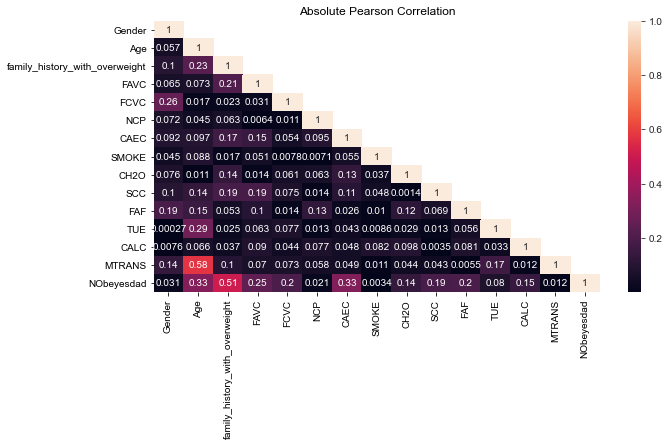

numeric abs(correlation) order: 
family_history_with_overweight    0.505148
Age                               0.332940
CAEC                              0.329350
FAVC                              0.247793
FAF                               0.197186
FCVC                              0.195705
SCC                               0.194508
CALC                              0.151752
CH2O                              0.138171
TUE                               0.079528
Gender                            0.031464
NCP                               0.020931
MTRANS                            0.011818
SMOKE                             0.003442
Name: NObeyesdad, dtype: float64


In [11]:
# correlation heatmap
corr_df = demo_df.corr().abs()

fig, ax = plt.subplots(figsize=(10,5))
sns.set_style('white')
mask = np.triu(np.ones_like(corr_df), k=1)
sns.heatmap(corr_df, annot=True, mask=mask, ax=ax).set(title='Absolute Pearson Correlation')

plt.show()
print("numeric abs(correlation) order: \n{}".format(corr_df['NObeyesdad'].sort_values(ascending=False)[1:]))

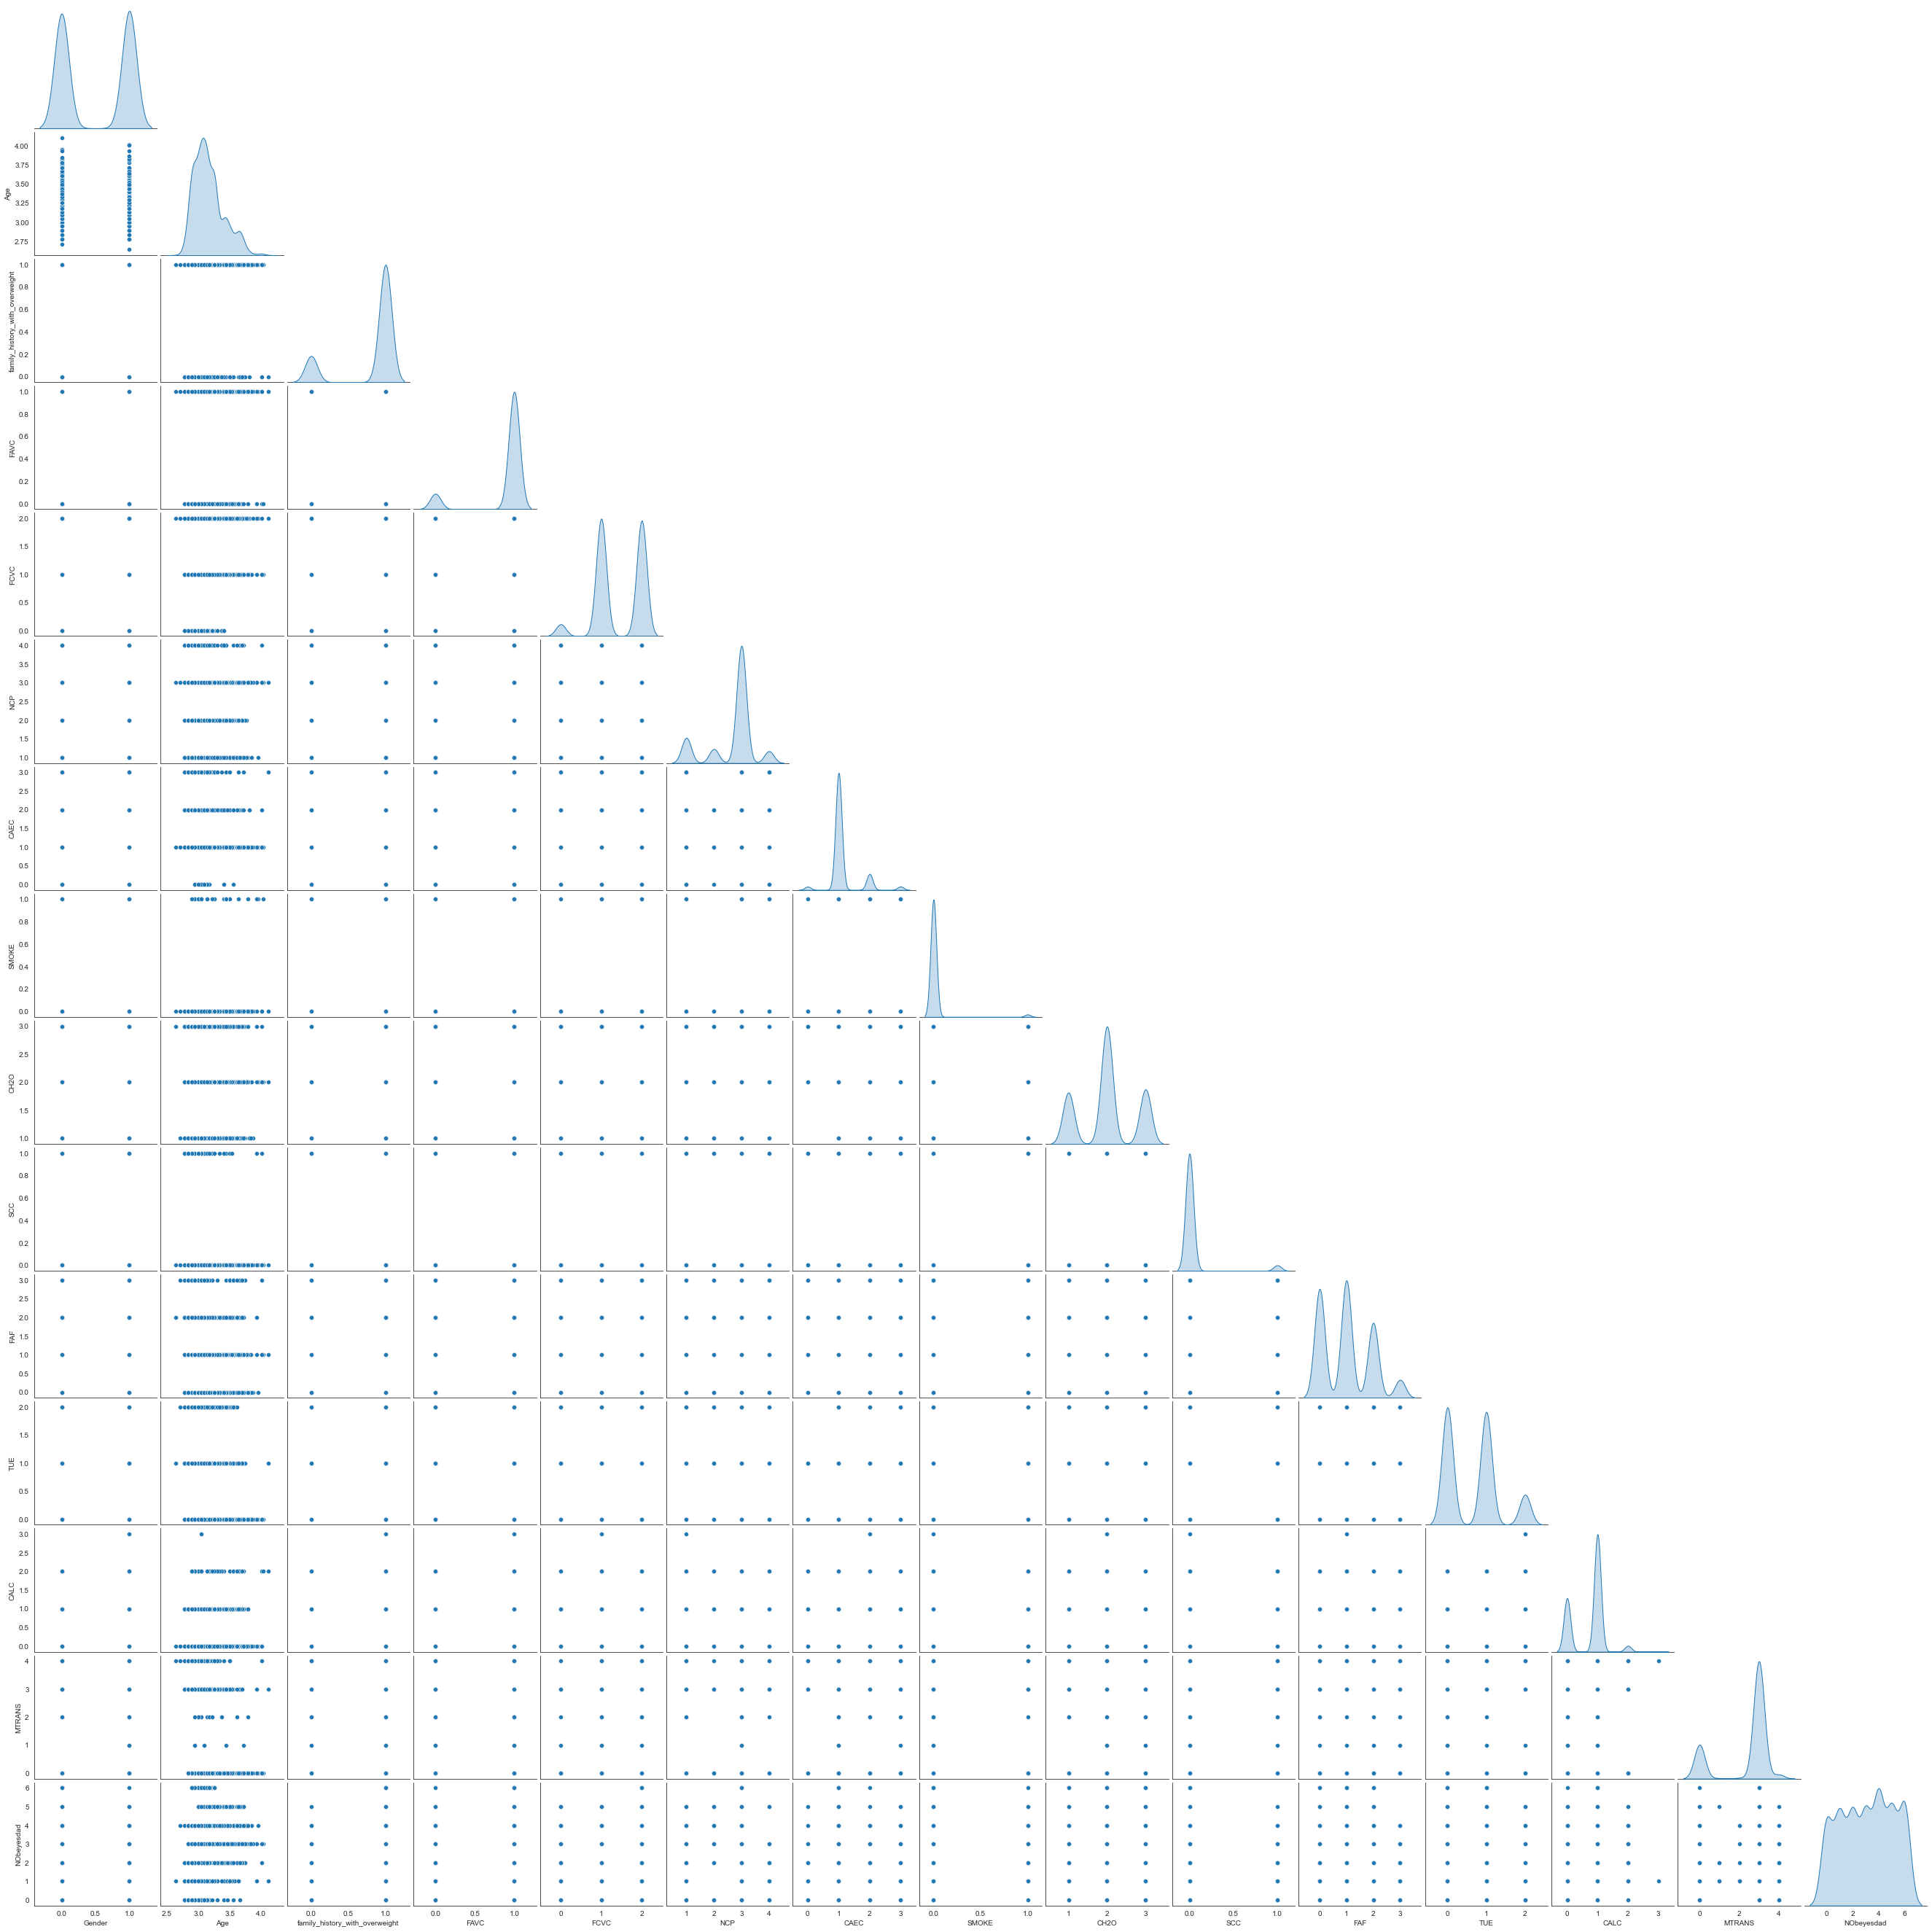

In [12]:
# plot only lower triangle due to symmetry
# shows mostly categorical distributions
sns.pairplot(demo_df, 
             corner=True, 
             diag_kind='kde')
plt.show()

# Train test split

In [13]:
# dropping target, Height, and Weight
col_to_drop = ["NObeyesdad", "Height", "Weight"] 
X = df.drop(columns=col_to_drop)
y = df["NObeyesdad"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

## Inspect X train

In [14]:
X_train

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
442,1,26.0,1,1,1.0,3.0,Sometimes,0,2.0,0,0.0,1.0,Sometimes,4
253,0,26.0,1,1,1.0,1.0,Sometimes,0,2.0,0,0.0,2.0,Sometimes,3
554,1,16.0,0,1,1.0,2.0,Sometimes,0,3.0,0,1.0,0.0,Sometimes,3
1500,1,24.0,1,1,1.0,3.0,Sometimes,0,1.0,0,0.0,1.0,no,0
359,0,33.0,1,0,1.0,3.0,Sometimes,0,2.0,0,1.0,0.0,Sometimes,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,1,19.0,0,1,1.0,4.0,Frequently,0,2.0,0,3.0,1.0,Frequently,0
840,1,20.0,1,1,2.0,3.0,Sometimes,0,3.0,0,2.0,0.0,Sometimes,3
1794,1,31.0,1,1,2.0,2.0,Sometimes,0,1.0,0,1.0,1.0,no,3
155,0,31.0,1,1,2.0,1.0,Frequently,0,2.0,0,1.0,1.0,Sometimes,0


## Data preparation for X_train

### Ordinal Encode

In [15]:
cols_to_ord = ["CAEC", "CALC"]

ord_enc = OrdinalEncoder(categories=[["no", "Sometimes", "Frequently", "Always"],
                                    ["no", "Sometimes", "Frequently", "Always"]])

X_train[cols_to_ord] = ord_enc.fit_transform(X_train[cols_to_ord])
X_test[cols_to_ord] = ord_enc.transform(X_test[cols_to_ord])
X_train.head()


,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
442,1,26.0,1,1,1.0,3.0,1.0,0,2.0,0,0.0,1.0,1.0,4
253,0,26.0,1,1,1.0,1.0,1.0,0,2.0,0,0.0,2.0,1.0,3
554,1,16.0,0,1,1.0,2.0,1.0,0,3.0,0,1.0,0.0,1.0,3
1500,1,24.0,1,1,1.0,3.0,1.0,0,1.0,0,0.0,1.0,0.0,0
359,0,33.0,1,0,1.0,3.0,1.0,0,2.0,0,1.0,0.0,1.0,3


See correlations of X_train

In [16]:
X_train.corr()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
Gender,1.000000,0.045974,0.095035,0.078526,-0.272743,0.081745,-0.092890,0.045388,0.056896,-0.098695,0.202470,0.015315,0.006922,-0.143400
Age,0.045974,1.000000,0.218257,0.083431,0.000779,-0.053270,-0.082336,0.094705,-0.034033,-0.121402,-0.127657,-0.283199,0.036785,-0.606381
family_history_with_overweight,0.095035,0.218257,1.000000,0.204672,0.009883,0.046047,-0.158420,0.003502,0.128790,-0.180247,-0.058395,0.024205,-0.029362,-0.106733
FAVC,0.078526,0.083431,0.204672,1.000000,-0.059913,-0.011639,-0.166281,-0.064057,0.012077,-0.199856,-0.118977,0.068491,0.119627,-0.079010
FCVC,-0.272743,0.000779,0.009883,-0.059913,1.000000,0.041271,0.069792,0.002427,0.052400,0.076476,0.021490,-0.087493,0.035553,0.083170
NCP,0.081745,-0.053270,0.046047,-0.011639,0.041271,1.000000,0.101231,0.005585,0.052512,0.000133,0.130696,0.004125,0.074801,-0.065573
CAEC,-0.092890,-0.082336,-0.158420,-0.166281,0.069792,0.101231,1.000000,0.055045,-0.121622,0.102785,0.034518,0.043418,-0.058633,0.043745
SMOKE,0.045388,0.094705,0.003502,-0.064057,0.002427,0.005585,0.055045,1.000000,-0.027992,0.066177,0.019631,0.018467,0.091905,-0.033637
CH2O,0.056896,-0.034033,0.128790,0.012077,0.052400,0.052512,-0.121622,-0.027992,1.000000,-0.005737,0.099436,-0.036897,0.096333,0.058086
SCC,-0.098695,-0.121402,-0.180247,-0.199856,0.076476,0.000133,0.102785,0.066177,-0.005737,1.000000,0.070929,-0.016485,-0.008174,0.044821


In [17]:
# Make sure values are encoded properly
X_train.FCVC.value_counts()

1.0    817
2.0    789
0.0     82
Name: FCVC, dtype: int64

### Normalize Age

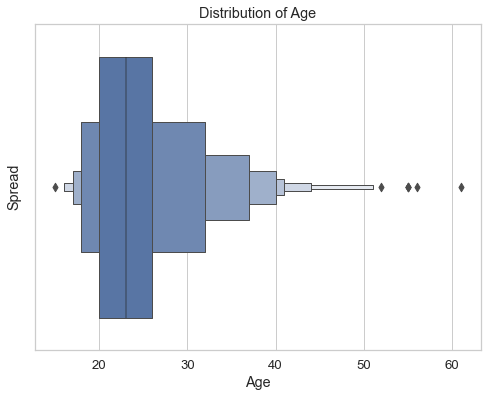

<Figure size 576x432 with 0 Axes>

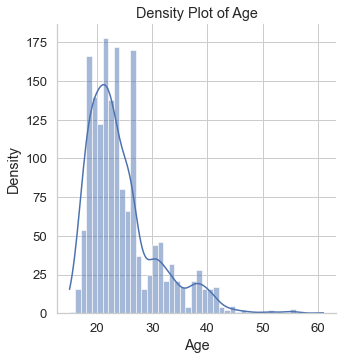

In [18]:
# Distribution is Laplace
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.boxenplot(X_train.Age)
plt.ylabel('Spread')
plt.title('Distribution of Age')
plt.show()

plt.figure(figsize=(8, 6))
sns.displot(X_train.Age, kde=True)
plt.ylabel('Density')
plt.title('Density Plot of Age')
plt.show()


Log Transform Age

In [19]:
# Log transform for a more normal distribution
X_train["Age"] = [np.log(x) for x in X_train["Age"]]
X_test["Age"] = [np.log(x) for x in X_test["Age"]]


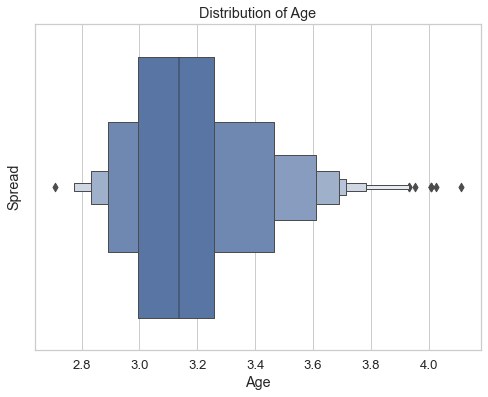

<Figure size 576x432 with 0 Axes>

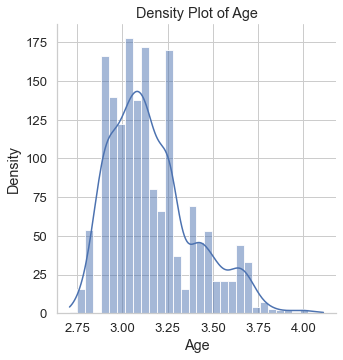

In [20]:
# show Age after transform
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.boxenplot(X_train.Age)
plt.ylabel('Spread')
plt.title('Distribution of Age')
plt.show()

plt.figure(figsize=(8, 6))
sns.displot(X_train.Age, kde=True)
plt.ylabel('Density')
plt.title('Density Plot of Age')
plt.show()

## Visualize columns in X_train

1    846
0    842
Name: Gender, dtype: int64

Text(0.5, 1.0, 'Distribution of Gender')

3.044522    178
3.135494    172
3.258097    170
2.890372    166
2.944439    140
3.091042    138
2.995732    122
3.178054     80
3.218876     66
2.833213     54
3.433987     46
3.401197     44
3.295837     37
3.496508     32
3.637586     28
3.367296     25
3.526361     21
3.465736     21
3.610918     21
3.713572     17
3.555348     17
3.663562     16
2.772589     16
3.332205     16
3.688879     16
3.784190      5
3.737670      4
3.583519      4
4.007333      3
3.761200      2
3.931826      2
3.828641      2
3.850148      1
3.806662      1
3.951244      1
4.110874      1
2.708050      1
4.025352      1
3.871201      1
Name: Age, dtype: int64

Text(0.5, 1.0, 'Distribution of Age')

1    1383
0     305
Name: family_history_with_overweight, dtype: int64

Text(0.5, 1.0, 'Distribution of family_history_with_overweight')

1    1492
0     196
Name: FAVC, dtype: int64

Text(0.5, 1.0, 'Distribution of FAVC')

1.0    817
2.0    789
0.0     82
Name: FCVC, dtype: int64

Text(0.5, 1.0, 'Distribution of FCVC')

3.0    1166
1.0     255
2.0     146
4.0     121
Name: NCP, dtype: int64

Text(0.5, 1.0, 'Distribution of NCP')

1.0    1414
2.0     188
3.0      43
0.0      43
Name: CAEC, dtype: int64

Text(0.5, 1.0, 'Distribution of CAEC')

0    1653
1      35
Name: SMOKE, dtype: int64

Text(0.5, 1.0, 'Distribution of SMOKE')

2.0    892
3.0    413
1.0    383
Name: CH2O, dtype: int64

Text(0.5, 1.0, 'Distribution of CH2O')

0    1609
1      79
Name: SCC, dtype: int64

Text(0.5, 1.0, 'Distribution of SCC')

1.0    619
0.0    582
2.0    401
3.0     86
Name: FAF, dtype: int64

Text(0.5, 1.0, 'Distribution of FAF')

0.0    769
1.0    728
2.0    191
Name: TUE, dtype: int64

Text(0.5, 1.0, 'Distribution of TUE')

1.0    1108
0.0     520
2.0      59
3.0       1
Name: CALC, dtype: int64

Text(0.5, 1.0, 'Distribution of CALC')

3    1256
0     373
4      44
2       9
1       6
Name: MTRANS, dtype: int64

Text(0.5, 1.0, 'Distribution of MTRANS')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

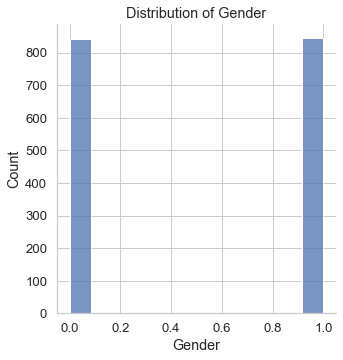

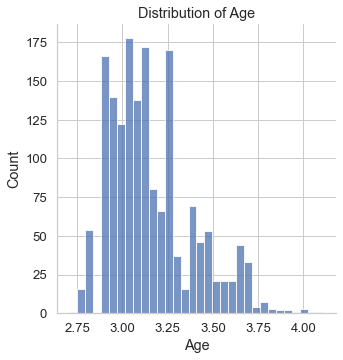

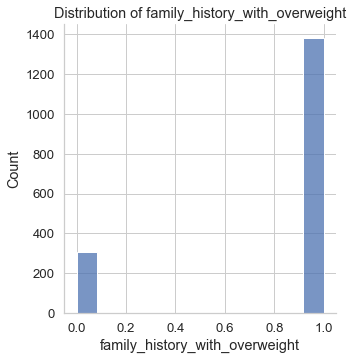

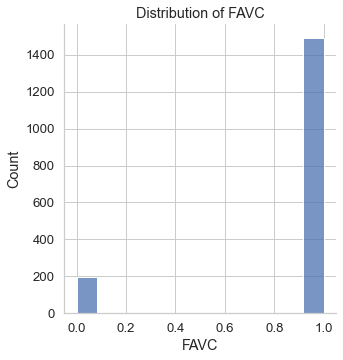

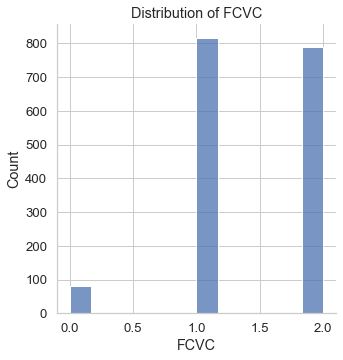

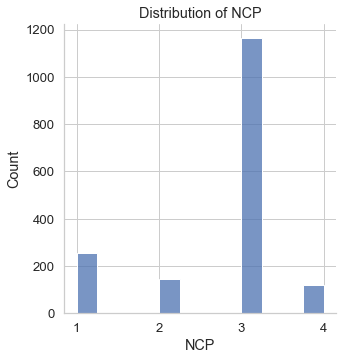

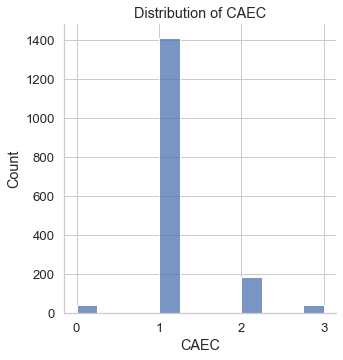

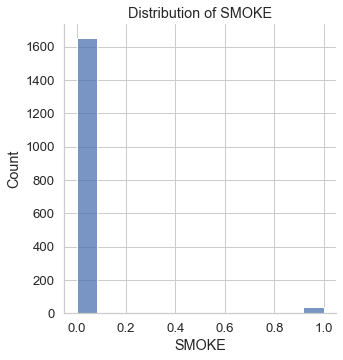

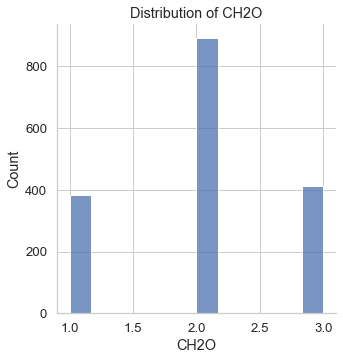

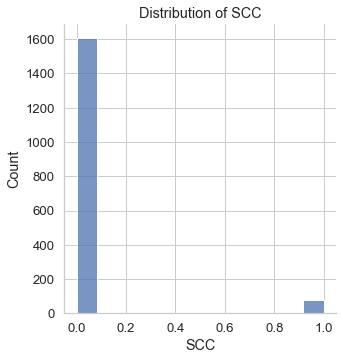

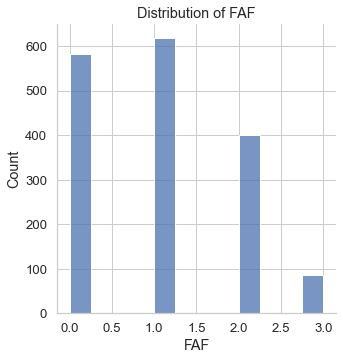

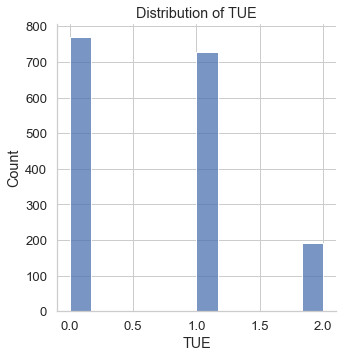

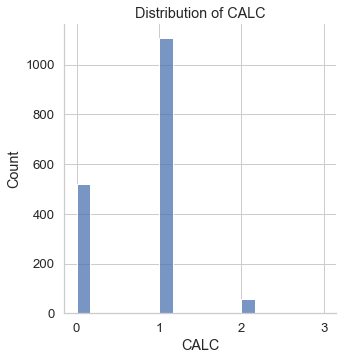

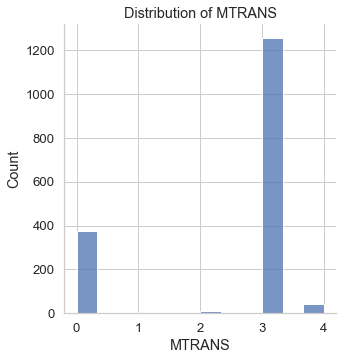

In [21]:
# quick inspect each column in X train to see distributions
sns.set(style='whitegrid', font_scale=1.2)
[display(sns.displot(X_train[x]), X_train[x].value_counts(), plt.title(f"Distribution of {x}")) for x in list(X_train.columns)]

### Check VIF

In [22]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
  
print(vif_data)

                           feature        VIF
0                           Gender   2.373448
1                              Age  38.073479
2   family_history_with_overweight   6.446876
3                             FAVC   9.606411
4                             FCVC   7.732581
5                              NCP  12.027061
6                             CAEC   7.313921
7                            SMOKE   1.051737
8                             CH2O  10.133575
9                              SCC   1.128639
10                             FAF   2.495818
11                             TUE   2.045901
12                            CALC   3.138217
13                          MTRANS   4.390265


VIF for Age is very high. Models were tested with and without Age. Age helped the models and boosted test accuracy across the board by about 7 basis points. 

# Model Testing

Test 1: Logistic Regression__OneHotEncoder

{}

0.6344793074991659

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('clf', LogisticRegression(random_state=42))])

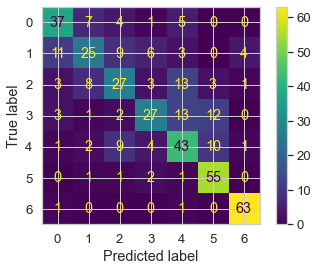

In [23]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ("clf", LogisticRegression(random_state=42))]

pipeline = Pipeline(steps)


# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

#estimated time to run commented out is around 40 min
pipe_grid = {
            # "hot_enc__drop": ["first", "if_binary"],
            # "hot_enc__handle_unknown": ["ignore"],
            # "clf__penalty": ["l1", "l2", "elasticnet", None],
            # "clf__max_iter": [x for x in range(0, 100, 10)],
            # "clf__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
            }


gs_pipe = GridSearchCV(estimator=pipeline, 
                       param_grid=pipe_grid,
                       n_jobs=-1
                       )

gs_pipe.fit(X_train, y_train)
display(gs_pipe.best_params_)
display(gs_pipe.best_score_)
display(gs_pipe.best_estimator_)

best_model = gs_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);


Test 2: K Nearest Neighbor__OneHotEncoder

{}

0.6872017277404175

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('knn', KNeighborsClassifier())])

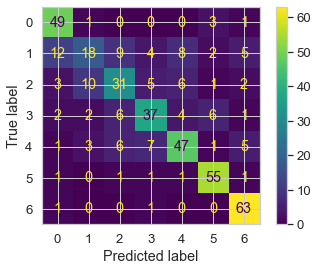

In [24]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ("knn", KNeighborsClassifier())]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

#estimated time to run commented out is around 20 min
pipe_grid = {
            #"hot_enc__handle_unknown": ["ignore", "infrequent_if_exist"],
            # 'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 18],
            # 'knn__p': [1, 2, 3, 4]
             }


gs_pipe = GridSearchCV(estimator=pipeline, 
                       param_grid=pipe_grid,
                       n_jobs=-1)

gs_pipe.fit(X_train, y_train)
display(gs_pipe.best_params_)
display(gs_pipe.best_score_)
display(gs_pipe.best_estimator_)
best_model = gs_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);

Test 3: Decision Tree__OneHotEncoder

{}

0.6931592716801573

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('rf_clf', DecisionTreeClassifier(random_state=42))])

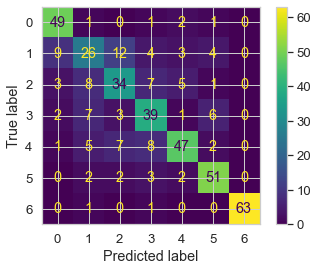

In [25]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ('rf_clf', DecisionTreeClassifier(random_state=42))]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

#estimated time to run commented out is around 40 min

pipe_grid = {
            # #"hot_enc__handle_unknown": ["ignore", "infrequent_if_exist"],
            # "rf_clf__criterion": ["gini", "entropy", "log_loss"],
            #  "rf_clf__splitter": ["best", "random"],
            #  "rf_clf__max_depth": [x for x in range(0,100,10)],
            #  "rf_clf__max_features": ["auto", "sqrt", "log2"]
            }

second_pipe = GridSearchCV(estimator=pipeline, 
                       param_grid=pipe_grid,
                       n_jobs=-1)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);

Test 4: Random Forest__OneHotEncoder

{'rf__criterion': 'entropy', 'rf__max_depth': 11, 'rf__max_features': 'sqrt'}

0.7417098309132092

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=11,
                                        max_features='sqrt',
                                        random_state=42))])

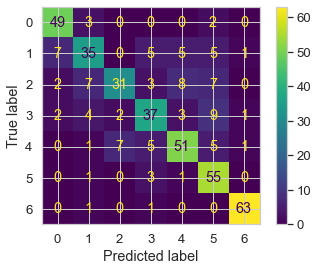

In [26]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ('rf', RandomForestClassifier(random_state=42))]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            #"hot_enc__handle_unknown": ["ignore"],
            # "rf__n_estimators": [x for x in range(450,500,10)],
             "rf__criterion": ["entropy"],
             "rf__max_depth": [11],
             "rf__max_features": ["sqrt"]
            }

second_pipe = GridSearchCV(estimator=pipeline, 
                       param_grid=pipe_grid,
                       n_jobs=-1)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);

Test 5: XGBoost__StandardScaler

0.8037825059101655


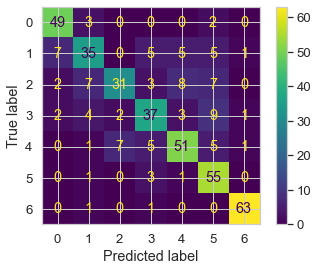

In [27]:
steps = [('std_scaler', StandardScaler()),('xgb_model', xgb.XGBClassifier())]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(pipeline.score(X_test, y_test))
plot_confusion_matrix(best_model,X_test,y_test);

Test 6: XGBoost__StandardScaler__SMOTE

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    3.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.7s finished


{'smote__k_neighbors': 5}

0.7831878917704073

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

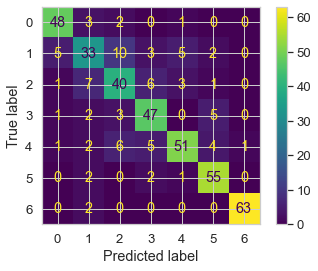

In [28]:
# Define the pipeline
pipeline = make_pipeline(SMOTE(random_state=42),
                         StandardScaler(),
                         xgb.XGBClassifier())

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the parameter grid for the pipeline
pipe_grid = {
    'smote__k_neighbors': [1, 3, 5]
}

# Define the GridSearchCV object
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV object
second_pipe.fit(X_train, y_train)

# Display the best hyperparameters, best score, and best estimator
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)

# Get the best model from the GridSearchCV object
best_model = second_pipe.best_estimator_

# Use the best model to make predictions on the test set
y_pred = best_model.predict(X_test)

# Plot the confusion matrix
plot_confusion_matrix(best_model, X_test, y_test);


Test 7: RandomForest__StandardScaler

{'rf__criterion': 'entropy',
 'rf__max_depth': 11,
 'rf__max_features': 'log2',
 'rf__n_estimators': 457}

0.7849577721981282

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=11,
                                        max_features='log2', n_estimators=457,
                                        random_state=42))])

array([0.12165457, 0.19170952, 0.08088179, 0.03886634, 0.09000181,
       0.07543686, 0.07454219, 0.00450825, 0.05122347, 0.01491348,
       0.06597757, 0.0530521 , 0.08183445, 0.05539759])

0.7872340425531915


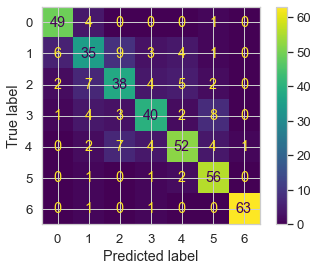

In [29]:
steps = [('std_scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            "rf__n_estimators": [457],
            "rf__criterion": ["entropy"],
            "rf__max_depth": [11],
            "rf__max_features": ["log2"]
            }

# note: default scoring is aaccuracy
second_pipe = GridSearchCV(estimator = pipeline,
                  param_grid = pipe_grid)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
feat_imp = best_model["rf"].feature_importances_
feat_imp_series = pd.Series(feat_imp, 
    index = X_train.columns).sort_values(
    ascending = False)
display(feat_imp)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
print(best_model.score(X_test, y_test))
plot_confusion_matrix(best_model,X_test,y_test);

In [30]:
# show columns of X_train
X_train.columns

Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'],
      dtype='object')

Test 8: Random Forest__StandardScaler__SMOTE 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


{'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__n_estimators': 456}

0.7890997840324478

Pipeline(steps=[('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=11,
                                        max_features='sqrt', n_estimators=456,
                                        n_jobs=-1, random_state=42))])

0.7777777777777778


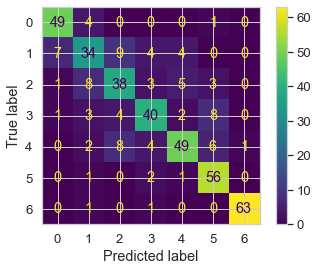

In [31]:
# Create pipeline with SMOTE, StandardScaler and RandomForestClassifier
pipeline = make_pipeline(
    # OneHotEncoder(handle_unknown="ignore", sparse=False),
    SMOTE(random_state=42, k_neighbors=1),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomforestclassifier__n_estimators": [456],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["sqrt"],
    "randomforestclassifier__class_weight": ["balanced_subsample"],
    "randomforestclassifier__min_impurity_decrease": [0.0]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    n_jobs=-1,
    verbose=2
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
print(best_model.score(X_test, y_test))
plot_confusion_matrix(best_model,X_test,y_test);


Test 9: Random Forest__StandardScaler__SMOTE

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_impurity_decrease': 1e-08,
 'randomforestclassifier__n_estimators': 457}

0.7891050515337208

Pipeline(steps=[('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=11,
                                        max_features='sqrt',
                                        min_impurity_decrease=1e-08,
                                        n_estimators=457, n_jobs=-1,
                                        random_state=42))])

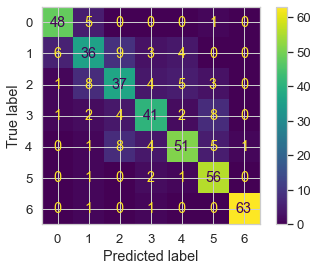

In [32]:
# Create pipeline with SMOTE, StandardScaler and RandomForestClassifier
pipeline = make_pipeline(
    # OneHotEncoder(handle_unknown="ignore", sparse=False),
    SMOTE(random_state=42, k_neighbors=1),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomforestclassifier__n_estimators": [457],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["sqrt","log2"],
    "randomforestclassifier__class_weight": ["balanced"],
    "randomforestclassifier__min_impurity_decrease": [0.00000001,],
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);


Test 10: Random Forest__StandardScaler__RandomOverSampler

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 457,
 'randomoversampler__sampling_strategy': {0: 281,
  1: 281,
  2: 281,
  3: 281,
  4: 281,
  5: 300,
  6: 259}}

0.7920636314153775

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={0: 281, 1: 281, 2: 281,
                                                      3: 281, 4: 281, 5: 300,
                                                      6: 259})),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=11,
                                        max_features='log2', n_estimators=457,
                                        random_state=42))])

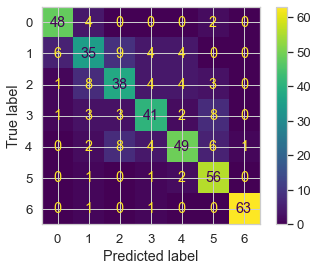

In [33]:
# Define the pipeline
pipeline = make_pipeline(
    RandomOverSampler(random_state=42),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomoversampler__sampling_strategy": [{0:281,1:281,2:281,3:281,4:281,5:300,6:259}],
    "randomforestclassifier__n_estimators": [457],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["log2"],
    "randomforestclassifier__class_weight": ["balanced", "balanced_subsample"]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);


Test 11: Guassian Bayes__StandardScaler__SMOTE

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


{}

0.5095201306340316

Pipeline(steps=[('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

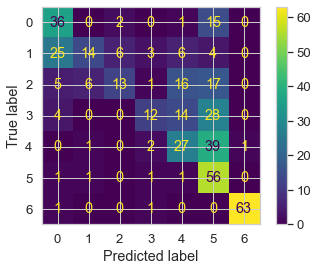

In [34]:
# Create pipeline with SMOTE, StandardScaler and RandomForestClassifier
pipeline = make_pipeline(
    # OneHotEncoder(handle_unknown="ignore", sparse=False),
    SMOTE(random_state=42, k_neighbors=1),
    StandardScaler(),
    GaussianNB()
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    verbose=2,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);

Test 12: Random Forest__StandardScaler__RandomOverSampler

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority, total=   1.0s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority, total=   1.0s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority, total=   1.0s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomfores

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority, total=   1.0s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority, total=   1.0s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=457, randomoversampler__sampling_strategy=minority 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomfores

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   34.7s finished


{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 457,
 'randomoversampler__sampling_strategy': 'not minority'}

0.7885063122223588

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='not minority')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=11,
                                        max_features='log2', n_estimators=457,
                                        random_state=42))])

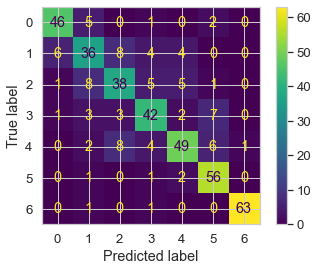

In [35]:
# Define the pipeline
pipeline = make_pipeline(
    RandomOverSampler(random_state=42),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomoversampler__sampling_strategy": ["minority","minority","minority","minority","minority","minority","not minority"],
    "randomforestclassifier__n_estimators": [457],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["log2"]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    verbose=2
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);


Test 13: Random Forest__Polynomial Features__OneHotEncoder

{'rf__criterion': 'entropy',
 'rf__max_depth': 11,
 'rf__max_features': 'log2',
 'rf__n_estimators': 464}

0.7417221217495127

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('poly', PolynomialFeatures()),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=11,
                                        max_features='log2', n_estimators=464,
                                        random_state=42))])

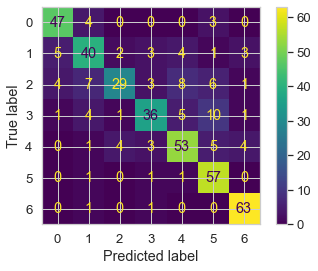

In [36]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ("poly", PolynomialFeatures()), ('rf', RandomForestClassifier(random_state=42))]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            #"hot_enc__handle_unknown": ["ignore"],
            "rf__n_estimators": [464],
            "rf__criterion": ["entropy"],
            "rf__max_depth": [11],
            "rf__max_features": ["log2"]
            }

# note: default scoring is aaccuracy
second_pipe = GridSearchCV(estimator = pipeline,
                  param_grid = pipe_grid,
                  n_jobs=-1)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);

# Baseline Model: Random Forest__StandardScaler__SMOTE

In [37]:
def gen_weights(num_cat):
    """
    Generate all possible combinations of weights for a given number of categories.

    Args:
    - num_cat (int): the number of categories to generate weights for.

    Returns:
    - A list of dictionaries, where each dictionary represents a unique combination of weights for each category.
      The keys of each dictionary are the category numbers (0 to num_cat - 1) and the values are the weights for each category.
    """
    master_weights = []
    weights = {}
    for cat in range(num_cat):
        weights.update({cat: .1})

    for i in range(num_cat):
        weight_values = list(np.arange(.4, 1.2, 0.2))
        weight_combinations = list(itertools.product(weight_values, repeat=num_cat))
        for combination in weight_combinations:
            temp_weights = weights.copy()
            for j in range(num_cat):
                temp_weights[j] = combination[j]
            master_weights.append(temp_weights.copy())
            
    return list(map(dict, set(frozenset(d.items()) for d in master_weights)))

weights = gen_weights(7)

len(weights)

16384

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': {0: 1.2000000000000002,
  1: 1.0,
  2: 1.0,
  3: 0.8,
  4: 1.2000000000000002,
  5: 0.6,
  6: 0.6},
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 456,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}

0.7956156831071233

Pipeline(steps=[('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 1.2000000000000002,
                                                      1: 1.0, 2: 1.0, 3: 0.8,
                                                      4: 1.2000000000000002,
                                                      5: 0.6, 6: 0.6},
                                        criterion='entropy', max_depth=11,
                                        max_features='sqrt', max_samples=0.6,
                                        min_impurity_decrease=0,
                                        n_estimators=456, oob_score=True,
                                        random_state=42, warm_start=True))])

array([0.09379391, 0.19810038, 0.08431835, 0.04367938, 0.07814037,
       0.07699818, 0.08260688, 0.00448546, 0.05568322, 0.01522204,
       0.07017576, 0.0590599 , 0.08200814, 0.05572803])

accuracy on test 0.7825059101654847
recall =  0.7809459651824184
f1_score =  0.7772203360117341


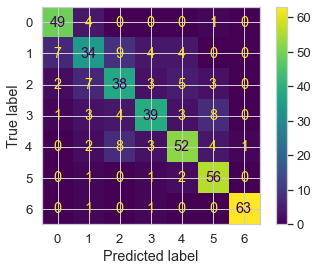

In [38]:
# Create pipeline with SMOTE, StandardScaler and RandomForestClassifier
pipeline = make_pipeline(
    # OneHotEncoder(handle_unknown="ignore", sparse=False),
    SMOTE(random_state=42, k_neighbors=1),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomforestclassifier__n_estimators": [456],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["sqrt"],
    "randomforestclassifier__class_weight": [{0: 1.2000000000000002, 1: 1.0, 2: 1.0, 3: 0.8, 4: 1.2000000000000002, 5: 0.6, 6: 0.6}],
    "randomforestclassifier__min_impurity_decrease": [0],
    "randomforestclassifier__min_samples_split": [2],
    "randomforestclassifier__min_samples_leaf": [1],
    "randomforestclassifier__max_samples": [0.6],
    "randomforestclassifier__bootstrap": [True],
    "randomforestclassifier__oob_score": [True],
    "randomforestclassifier__warm_start": [True]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    verbose=2,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
feat_imp = best_model["randomforestclassifier"].feature_importances_
feat_imp_series = pd.Series(feat_imp, 
    index = X_train.columns).sort_values(
    ascending = False)
display(feat_imp)
X_train.columns
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)

print("accuracy on test", best_model.score(X_test, y_test))
print("recall = ", recall_score(y_test, y_pred, average="macro"))
print("f1_score = ", f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(best_model,X_test,y_test);

Further validating and comparing base model vs other options using a StackingRegressor

In [ ]:
from imblearn.pipeline import Pipeline


# Create pipeline with SMOTE, StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "rf__n_estimators": [456],
    "rf__criterion": ["entropy"],
    "rf__max_depth": [11],
    "rf__max_features": ["sqrt"],
    "rf__class_weight": [{0: 1.2000000000000002, 1: 1.0, 2: 1.0, 3: 0.8, 4: 1.2000000000000002, 5: 0.6, 6: 0.6}],
    "rf__min_impurity_decrease": [0],
    "rf__min_samples_split": [2],
    "rf__min_samples_leaf": [1],
    "rf__max_samples": [0.6],
    "rf__bootstrap": [True],
    "rf__oob_score": [True],
    "rf__warm_start": [True]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    verbose=2,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)

# Fit the stacking regressor to the predicted X values and the true labels
estimators = [
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor()),
    ('rt', DecisionTreeRegressor()),
]
sr = StackingRegressor(estimators)
final_p = Pipeline([('model', sr)])
final_p.fit(predicted.reshape(-1, 1), y_test)

# Get the best model from the grid search
best_model = second_pipe.best_estimator_
display(best_model)
display(second_pipe.best_score_)
# Get the feature importances of the best model
feat_imp = best_model.named_steps['rf'].feature_importances_
feat_imp_series = pd.Series(feat_imp, index=X_train.columns).sort_values(ascending=False)
display(feat_imp)
# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Plot the confusion matrix for the best model
plot_confusion_matrix(best_model, X_test, y_test);



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


# Final Model

In [ ]:
pipeline = make_pipeline(
    # OneHotEncoder(handle_unknown="ignore", sparse=False),
    # SMOTE(random_state=42, k_neighbors=1),
    StandardScaler(),
    xgb.XGBClassifier())

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

pipe_grid = {
    'xgbclassifier__learning_rate': [0.1],
    'xgbclassifier__n_estimators': [200],
    'xgbclassifier__max_depth': [7],
    'xgbclassifier__min_child_weight': [1],
    'xgbclassifier__gamma': [0],
    'xgbclassifier__subsample': [0.8],
    'xgbclassifier__colsample_bytree': [0.6]
}

second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    verbose=2,
    n_jobs=-1,
    cv=5
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)

feat_imp = best_model["xgbclassifier"].feature_importances_
feat_imp_series = pd.Series(feat_imp, 
    index = X_train.columns).sort_values(
    ascending = False)
display(feat_imp)
display(X_train.columns)

print("accuracy on test", best_model.score(X_test, y_test))
print("recall = ", recall_score(y_test, y_pred, average="macro"))
print("f1_score = ", f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(best_model,X_test,y_test);

## Create probability distribution to inspect Gender by weight class in the data
Investigating why there is severe misclassification occuring on True Label 6 and Predicted Label 1

In [ ]:
# Returns an iteration of probabilities for males and females for their weight class

# Count the number of males and females
num_male = (df['Gender'] == 1).sum()
num_female = (df['Gender'] == 0).sum()

# Initialize a list to store the results
probabilities_male = []
probabilities_female = []

# Calculate the probabilities for each category of NObeyesdad equal to 2
for i in range(2, 7):
    # Count the number of overweight males and females
    num_overweight_male = ((df['Gender'] == 1) & (df['NObeyesdad'] == i)).sum()
    num_overweight_female = ((df['Gender'] == 0) & (df['NObeyesdad'] == i)).sum()

    # Calculate the overall probabilities
    p_male = num_male / len(df)
    p_female = num_female / len(df)
    p_overweight = (num_overweight_male + num_overweight_female) / len(df)

    # Calculate the conditional probability for males
    p_overweight_given_male = (num_overweight_male / len(df)) * p_overweight / p_male
    probabilities_male.append(p_overweight_given_male)

    # Calculate the conditional probability for females
    p_overweight_given_female = (num_overweight_female / len(df)) * p_overweight / p_female
    probabilities_female.append(p_overweight_given_female)

# Print the results for males
for i, prob in enumerate(probabilities_male):
    category = i + 2
    print("If you are male and in category", category, "the probability of being overweight is:", prob)

# Print the results for females
for i, prob in enumerate(probabilities_female):
    category = i + 2
    print("If you are female and in category", category, "the probability of being overweight is:", prob)


# Create a data frame with the probabilities for males and females
data = pd.DataFrame({
    'Gender': ['Male']*5 + ['Female']*5,
    'Category': [2, 3, 4, 5, 6]*2,
    'Probability': probabilities_male + probabilities_female
})

# Set the style of the chart
sns.set(style="whitegrid")

# Create a bar plot with the probabilities
sns.catplot(x="Category", y="Probability", hue="Gender", data=data, kind="bar", height=6, aspect=1.2)
plt.xlabel("NObeyesdad Category")
plt.ylabel("Probability of Being Overweight")
plt.title("Probability Distribution of Overweight/Obese Classes by Gender");
data

Now we see that there are no male samples in the Obesity class 6; reason for misclassification

# Best iterations on base models stored

In [ ]:
{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 457,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}
0.7369708356012853

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.5,
 'randomforestclassifier__min_impurity_decrease': 1e-08,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 457,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}
0.7363791196249538

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 457,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}
0.7369708356012853


{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': {0: 1.0,
  1: 1.15,
  5: 1.2999999999999998,
  6: 1.2999999999999998,
  2: 1.15,
  3: 1.15,
  4: 1.2999999999999998},
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 456,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}
0.7944392744894914

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': {0: 1.2000000000000002,
  2: 1.0,
  3: 0.8,
  1: 1.0,
  5: 0.6,
  6: 0.6,
  4: 1.2000000000000002},
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 456,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}
0.7956156831071233

y_train.value_counts()

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': {0: 1.2000000000000002,
  2: 1.0,
  3: 0.8,
  1: 1.0,
  5: 0.6,
  6: 0.6,
  4: 1.2000000000000002},
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 456,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}
0.7956156831071233


{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': {0: 1.2000000000000002,
  1: 1.0,
  2: 1.0,
  3: 0.8,
  4: 1.2000000000000002,
  5: 0.6,
  6: 0.6},
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 456,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}
0.7956156831071233